# CatBoost (GBDT) experiments.

Import dependencies.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr as pearson

from preprocessors.preprocessor import Preprocessor

from preprocessors.scalers.min_max_scaler import MinMaxScalerData
from preprocessors.scalers.log_increases_scaler import LogIncreasesScalerData

from models.catboost.union_catboost import UnionCatBoost
from models.catboost.multi_catboost import MultiCatBoost, GreedyMultiCatBoost

from models.catboost.catboost_evaluator import Evaluator as CatBoostEvaluator

from preprocessors.extrapolate_functions import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def mape(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    return np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))

If using Google Colab uncomment the cell below.

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
DATA_PATH = "../data/BRDT_GAS_2007.csv"
train_size = 4000
val_size = 450
max_train_horizons = 55
max_prediction_horizons = 30
d_size = 5

In [5]:
df = pd.read_csv(DATA_PATH)

In [6]:
df.head()

,EUCRBRDT Comdty,RUB CBRF Curncy,EURUSD Curncy,TTFG1MON Index,Date
0,76.15,25.5708,1.3802,16.40,9/10/07
1,76.67,25.5154,1.3839,16.23,9/11/07
2,78.33,25.4056,1.3904,17.05,9/12/07
3,77.94,25.3679,1.3885,16.83,9/13/07
4,76.81,25.3422,1.3875,17.05,9/14/07


Let's try to use MinMaxScalerData to see, what happens.

In [7]:
scaler=MinMaxScalerData(train_size=train_size)
# scaler = LogIncreasesScalerData(train_size=train_size)

preprocessor = Preprocessor(
    dataset=df.iloc[:, :].to_numpy(),
    max_pred_horizon=max_prediction_horizons,
    max_train_horizon=max_train_horizons,
    d_size=d_size,
    extrapolator_x=x_linear_piecewise,
    extrapolator_y=y_linear_piecewise,
)

Using cpu


In [8]:
preprocessor.train_val_test_split(
    train_size=train_size,
    val_size=val_size,
    scaler=scaler,
    use_tqdm=True,
)

100%|██████████| 87/87 [00:00<00:00, 14621.91it/s]


In [9]:
test_size = preprocessor.x_test.shape[0]

Check the plot for each row.

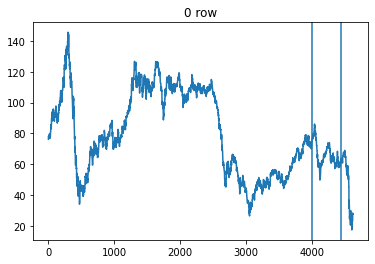

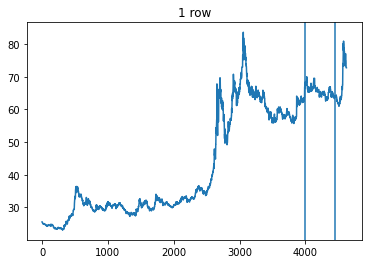

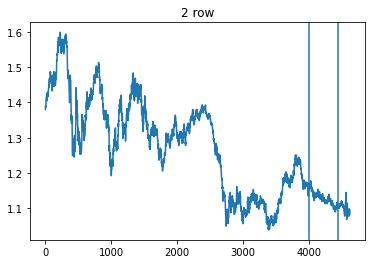

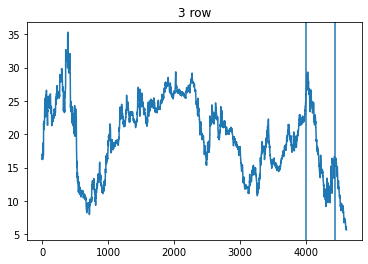

In [10]:
for row_ind in range(d_size-1):
    preprocessor.plot_row(row=row_ind)

As we can see, there is no point to predict for 0, 3 and 4 rows because the range of values in validation and test part significantly differes from the train part.

Let's try to predict mean for row with index 1 on values of rows 1-2.

In [13]:
mae_union_catboost_eval_linear = CatBoostEvaluator(
    regressor=UnionCatBoost,
    preprocessor=preprocessor,
    function_x_train=lambda x: x.reshape(train_size, -1),
    function_y_train=lambda y: y[:, :, 0].mean(axis=-1),
    function_x_val=lambda x: x.reshape(val_size, -1),
    function_y_val=lambda y: y[:, :, 0].mean(axis=-1),
    function_x_test=lambda x: x.reshape(test_size, -1),
    function_y_test=lambda y: y[:, :, 0].mean(axis=-1),
    train_horizons=[7, 10, 14, 17, 21, 24, 28, 31, 35, 39, 42],
    prediction_horizons=[7, 14, 21],
    metric=mean_absolute_error,
    metric_name='MAE',
    loss_function='MAE',
    grid_search_params={
        'verbose': [500],
        'has_time': [True, False],
        'iterations': [4000],
        'depth': [6, 7, 8, 9, 10, 11, 12],
        'max_bin': [None, 32, 46, 100, 254],
        'l2_leaf_reg': [None, 2, 10, 20, 30],
        'bagging_temperature': [None, 0, 0.5, 1],
        'random_strength': [None, 1, 5, 10],
    },
    use_gpu=False,
)

In [ ]:
mae_union_catboost_eval_linear.evaluate_params()

Train_horizon: 7
Prediction_horizon: 7
Estimator params: {'verbose': 500, 'has_time': True, 'iterations': 4000, 'depth': 6, 'max_bin': None, 'l2_leaf_reg': None, 'bagging_temperature': None, 'random_strength': None}
0:	learn: 0.1955890	test: 0.1129812	best: 0.1129812 (0)	total: 5.04ms	remaining: 20.2s
500:	learn: 0.0098576	test: 0.0216005	best: 0.0210309 (34)	total: 1.73s	remaining: 12.1s
1000:	learn: 0.0074741	test: 0.0217599	best: 0.0210309 (34)	total: 3.97s	remaining: 11.9s
1500:	learn: 0.0063372	test: 0.0219232	best: 0.0210309 (34)	total: 5.87s	remaining: 9.77s
2000:	learn: 0.0055586	test: 0.0223391	best: 0.0210309 (34)	total: 7.75s	remaining: 7.74s
2500:	learn: 0.0049916	test: 0.0227274	best: 0.0210309 (34)	total: 10.1s	remaining: 6.03s
3000:	learn: 0.0044873	test: 0.0227090	best: 0.0210309 (34)	total: 11.8s	remaining: 3.93s
3500:	learn: 0.0041576	test: 0.0229313	best: 0.0210309 (34)	total: 13.9s	remaining: 1.98s
3999:	learn: 0.0038663	test: 0.0230364	best: 0.0210309 (34)	total: 1

1000:	learn: 0.0081398	test: 0.0322875	best: 0.0267285 (31)	total: 3.31s	remaining: 9.93s
1500:	learn: 0.0065452	test: 0.0320930	best: 0.0267285 (31)	total: 5.07s	remaining: 8.45s
2000:	learn: 0.0055393	test: 0.0323557	best: 0.0267285 (31)	total: 6.77s	remaining: 6.76s
2500:	learn: 0.0049491	test: 0.0328100	best: 0.0267285 (31)	total: 8.81s	remaining: 5.28s
3000:	learn: 0.0044284	test: 0.0329815	best: 0.0267285 (31)	total: 10.7s	remaining: 3.55s
3500:	learn: 0.0040350	test: 0.0333642	best: 0.0267285 (31)	total: 12.4s	remaining: 1.77s
3999:	learn: 0.0037505	test: 0.0334264	best: 0.0267285 (31)	total: 14.7s	remaining: 0us

bestTest = 0.0267284984
bestIteration = 31

Shrink model to first 32 iterations.
(450, 1)
(450,)
Best shift: 7
Train_horizon: 7
Prediction_horizon: 7
Estimator params: {'verbose': 500, 'has_time': True, 'iterations': 4000, 'depth': 6, 'max_bin': None, 'l2_leaf_reg': None, 'bagging_temperature': 0.5, 'random_strength': None}
0:	learn: 0.1955890	test: 0.1129812	best: 0.1

3000:	learn: 0.0044035	test: 0.0279837	best: 0.0231050 (34)	total: 16.4s	remaining: 5.46s
3500:	learn: 0.0040510	test: 0.0283439	best: 0.0231050 (34)	total: 18.4s	remaining: 2.63s
3999:	learn: 0.0037366	test: 0.0286231	best: 0.0231050 (34)	total: 20.9s	remaining: 0us

bestTest = 0.02310502137
bestIteration = 34

Shrink model to first 35 iterations.
(450, 1)
(450,)
Best shift: 8
Train_horizon: 7
Prediction_horizon: 7
Estimator params: {'verbose': 500, 'has_time': True, 'iterations': 4000, 'depth': 6, 'max_bin': None, 'l2_leaf_reg': None, 'bagging_temperature': 1, 'random_strength': 10}
0:	learn: 0.1956597	test: 0.1129520	best: 0.1129520 (0)	total: 3.07ms	remaining: 12.3s
500:	learn: 0.0116830	test: 0.0349085	best: 0.0267285 (31)	total: 2.21s	remaining: 15.4s
1000:	learn: 0.0081398	test: 0.0322875	best: 0.0267285 (31)	total: 4.06s	remaining: 12.2s
1500:	learn: 0.0065452	test: 0.0320930	best: 0.0267285 (31)	total: 6.07s	remaining: 10.1s
2000:	learn: 0.0055393	test: 0.0323557	best: 0.02672

In [ ]:
mae_union_catboost_eval.form_result_table(
    metric_names=['MAE', 'MSE', 'RMSE', 'MAPE', 'pearson'],
    metrics=[mean_absolute_error, mean_squared_error, rmse, mape, pearson],
    part='test',
    is_real_data=True,
)

In [ ]:
mse_union_catboost_eval_linear = CatBoostEvaluator(
    regressor=UnionCatBoost,
    preprocessor=preprocessor,
    function_x_train=lambda x: x.reshape(train_size, -1),
    function_y_train=lambda y: y[:, :, 0].mean(axis=-1),
    function_x_val=lambda x: x.reshape(val_size, -1),
    function_y_val=lambda y: y[:, :, 0].mean(axis=-1),
    function_x_test=lambda x: x.reshape(test_size, -1),
    function_y_test=lambda y: y[:, :, 0].mean(axis=-1),
    train_horizons=[7],
    prediction_horizons=[7],
    train_horizons=[7, 10, 14, 17, 21, 24, 28, 31, 35, 39, 42],
    prediction_horizons=[7, 14, 21],
    metric=mean_squared_error,
    metric_name='MSE',
    loss_function='MSE',
    grid_search_params={
        'verbose': [500],
        'has_time': [True, False],
        'iterations': [4000],
        'depth': [6, 7, 8, 9, 10, 11, 12],
        'max_bin': [None, 32, 46, 100, 254],
        'l2_leaf_reg': [None, 2, 10, 20, 30],
        'bagging_temperature': [None, 0, 0.5, 1],
        'random_strength': [None, 1, 5, 10],
    },
    use_gpu=False,
)

In [ ]:
mse_union_catboost_eval_linear.evaluate_params()

In [ ]:
mse_union_catboost_eval.form_result_table(
    metric_names=['MAE', 'MSE', 'RMSE', 'MAPE', 'pearson'],
    metrics=[mean_absolute_error, mean_squared_error, rmse, mape, pearson],
    part='test',
    is_real_data=True,
)

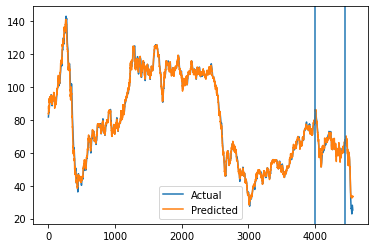

In [130]:
#Linear
mae_union_catboost_eval.plot_union(
    train_horizon=7,
    pred_horizon=7,
    start_ind=0,
    end_ind=None,
)

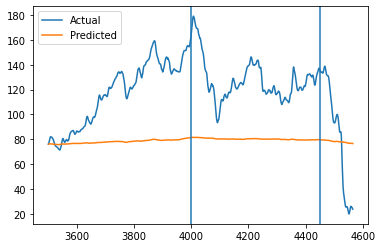

In [29]:
#Linear
mae_union_catboost_eval.plot_union(
    train_horizon=7,
    pred_horizon=7,
    start_ind=3500,
    end_ind=None,
)

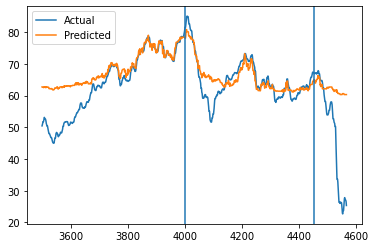

In [189]:
#Sparse
mae_union_catboost_eval.plot_union(
    train_horizon=5,
    pred_horizon=5,
    start_ind=3500,
    end_ind=None,
)

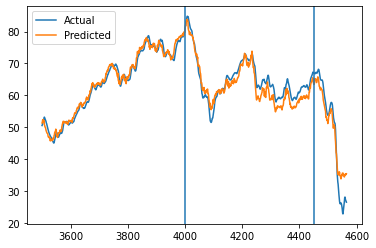

In [142]:
#Liner
mae_union_catboost_eval.plot_union(
    train_horizon=7,
    pred_horizon=7,
    start_ind=3500,
    end_ind=None,
)

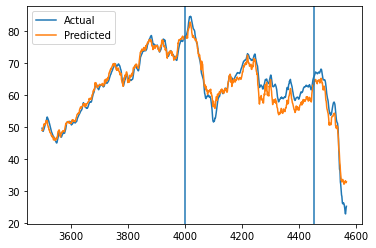

In [16]:
#Flat
mae_union_catboost_eval.plot_union(
    train_horizon=7,
    pred_horizon=7,
    start_ind=3500,
    end_ind=None,
)

In [48]:
y_val[0]

array([[0.5383283432695304, 0.5292372006643274, 0.39916555457382846,
        0.4409297686806828],
       [0.5871013252376518, 0.540512819077245, 0.41216718120623497,
        0.43754255964337324],
       [0.47772330285317616, 0.5347817439178307, 0.44107562079712054,
        0.3542523688876939],
       [0.45873126090694927, 0.5191828006083985, 0.37312788338023073,
        0.27555242875973696],
       [0.46419435413573074, 0.5363040788869389, 0.2711490341941445,
        0.32226499664530545],
       [0.5285681583598496, 0.5454300522923032, 0.3595138804017683,
        0.3637424480223535],
       [0.5386313016626242, 0.5437909745539505, 0.3648406868995371,
        0.38565680326167046]], dtype=object)

In [49]:
dates_val[0]

array([datetime.datetime(2018, 9, 23, 0, 0),
       datetime.datetime(2018, 9, 24, 0, 0),
       datetime.datetime(2018, 9, 25, 0, 0),
       datetime.datetime(2018, 9, 26, 0, 0),
       datetime.datetime(2018, 9, 27, 0, 0),
       datetime.datetime(2018, 9, 28, 0, 0),
       datetime.datetime(2018, 9, 29, 0, 0)], dtype=object)

In [80]:
y_val, dates_val = preprocessor.get_y_part('val', 7)

y_val_work_days = []
for ind, y_elem in enumerate(y_val):
    y_elements = []
    for num, value in enumerate(y_elem):
        if date.weekday(dates_val[ind][num]) not in [5, 6]:
            y_elements.append(value)
    y_val_work_days.append(
        np.array(y_elements)[np.newaxis, :, :][:, :, 0],
    )
y_val_work_days = np.array(y_val_work_days)

In [81]:
y_val_work_days = y_val_work_days.squeeze(axis=1)

In [83]:
y_val_work_days.shape

(450, 5)

Using the same method min/max/value on n-th day from the current can be predicted.

Let's try to deal with multi-target output.

Let's initially use MultiRMSE - the only loss-function, supported for honest multi-target output in GBDT.

In [168]:
mae_multi_catboost_eval = CatBoostEvaluator(
    regressor=MultiCatBoost,
    preprocessor=preprocessor,
    function_x_train=lambda x: x.reshape(train_size, -1),
    function_y_train=lambda y: y[:, :, 0],
    function_x_val=lambda x: x.reshape(val_size, -1),
    function_y_val=lambda y: y[:, :, 0],
    function_x_test=lambda x: x.reshape(test_size, -1),
    function_y_test=lambda y: y[:, :, 0],
    train_horizons=[14],
    prediction_horizons=[7],
    metric=mean_absolute_error,
    metric_name='MAE',
    loss_function='MultiRMSE',
    grid_search_params={
        'verbose': [500],
        'has_time': [True],
#         'depth': [8],
        'iterations': [5000],
    },
    use_gpu=False,
)

In [169]:
mae_multi_catboost_eval.evaluate_params()

Train_horizon: 14
Prediction_horizon: 7
Estimator params: {'verbose': 500, 'has_time': True, 'iterations': 5000}
0:	learn: 1.3242198	test: 0.8189661	best: 0.8189661 (0)	total: 50.9ms	remaining: 4m 14s
500:	learn: 0.0437591	test: 0.1152040	best: 0.1146953 (490)	total: 9.88s	remaining: 1m 28s
1000:	learn: 0.0331406	test: 0.1139011	best: 0.1132356 (763)	total: 20.2s	remaining: 1m 20s
1500:	learn: 0.0273678	test: 0.1122347	best: 0.1121056 (1476)	total: 30.5s	remaining: 1m 11s
2000:	learn: 0.0236631	test: 0.1109975	best: 0.1109598 (1994)	total: 40.9s	remaining: 1m 1s
2500:	learn: 0.0209448	test: 0.1104726	best: 0.1104726 (2500)	total: 51.2s	remaining: 51.1s
3000:	learn: 0.0187807	test: 0.1110158	best: 0.1103080 (2774)	total: 1m 1s	remaining: 41.2s
3500:	learn: 0.0170420	test: 0.1115596	best: 0.1103080 (2774)	total: 1m 14s	remaining: 31.7s
4000:	learn: 0.0156441	test: 0.1114047	best: 0.1103080 (2774)	total: 1m 26s	remaining: 21.6s
4500:	learn: 0.0143747	test: 0.1116767	best: 0.1103080 (2774)

In [170]:
mae_multi_catboost_eval.form_result_table(
    metric_names=['MAE'],
    metrics=[mean_absolute_error],
    part='test',
    is_real_data=False,
)

Loss function: MultiRMSE
Metric: MAE
           7
14  0.047769
_____________________


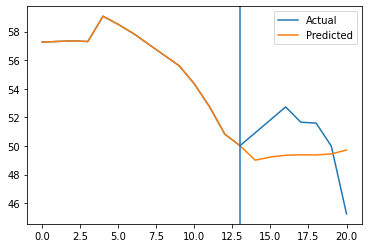

In [211]:
mae_multi_catboost_eval.plot_multi(
    train_horizon=14,
    pred_horizon=7,
    start_ind=4500,
)

In [164]:
preprocessor.get_x_part('train', 14)[0, :, 0]

array([0.4863475028646489, 0.4845308962857383, 0.47413431709566534,
       0.4845308962857383, 0.5094323803135743, 0.5193258992202566,
       0.5241888152930326, 0.5290517313658087, 0.5339146474385847,
       0.5149660434308712, 0.5357592018110171, 0.5334115871551942,
       0.5542047455353399, 0.5501243676811716], dtype=object)

Well, not everything that bad:)

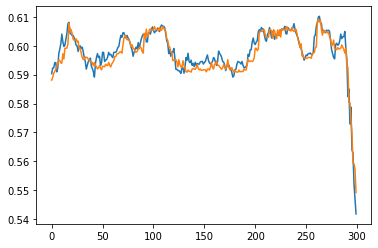

In [16]:
plt.plot(preprocessor.y_test[:, 8, 1][:300])
plt.plot(mae_multi_catboost_eval.best_model[14][10].predict(preprocessor.x_test[12:, -14:, 1])[:, 8][0:300])

Let's try GreedyMultiCatBoost.

In [17]:
mae_greedy_catboost_eval = CatBoostEvaluator(
    regressor=GreedyMultiCatBoost,
    preprocessor=preprocessor,
    function_x=lambda x: x[:, :, 1],
    function_y=lambda y: y[:, :, 1],
    train_horizons=train_horizons,
    prediction_horizons=prediction_horizons,
    metric=mean_absolute_error,
    metric_name='MAE',
    loss_function='MAE',
    grid_search_params={
        'silent': [True],
        'has_time': [True],
        'depth': [8]
    },
    use_gpu=False,
)

In [18]:
mae_greedy_catboost_eval.evaluate_params()

Train_horizon: 7
Prediction_horizon: 5
Estimator params: {'silent': True, 'has_time': True, 'depth': 8}
Best shift: 5
Best estimator params: {'silent': True, 'has_time': True, 'depth': 8}
Train_horizon: 7
Prediction_horizon: 10
Estimator params: {'silent': True, 'has_time': True, 'depth': 8}
Best shift: 8
Best estimator params: {'silent': True, 'has_time': True, 'depth': 8}
Train_horizon: 14
Prediction_horizon: 5
Estimator params: {'silent': True, 'has_time': True, 'depth': 8}
Best shift: 5
Best estimator params: {'silent': True, 'has_time': True, 'depth': 8}
Train_horizon: 14
Prediction_horizon: 10
Estimator params: {'silent': True, 'has_time': True, 'depth': 8}
Best shift: 9
Best estimator params: {'silent': True, 'has_time': True, 'depth': 8}


In [19]:
mae_greedy_catboost_eval.form_table()

Metric: MAE
Loss function: MAE
          7         14
5   0.002529  0.003161
10  0.002843  0.003369


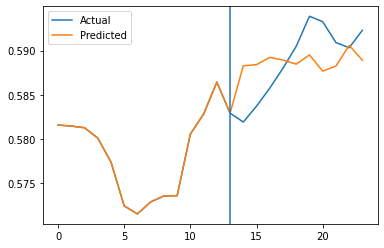

In [20]:
mae_greedy_catboost_eval.plot_multi(
    train_horizon=14,
    pred_horizon=10,
    start_ind=35000,
)